In [1]:
sc

<SparkContext master=local[*] appName=pyspark-shell>

# Study Station 235 Castrcum (Amsterdan) LSTM

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from IPython.display import display, HTML
from dateutil.parser import parse 
from pyspark.sql.types import *
from pyspark.sql.functions import *
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

In [5]:
def get_final_data(freq, filter_year = 1951):
    hadoopUrl = 'hdfs://hadoop-vm.internal.cloudapp.net:9000'
    data_files = f'{hadoopUrl}/precipitation/data/agg/final/*.parquet'

    # Obtain dataset
    df = spark.read.parquet(data_files) \
            .withColumn("precipitation", col("precipitation").cast("float")) \
            .select("date","precipitation") \
            .toPandas()
    
    # Set the date column as the index and ensure it's a DatetimeIndex
    df.set_index('date', inplace=True)
    df.index = pd.to_datetime(df.index)
    
    # Filter years
    df[df.index.year > filter_year] # Only 1951 onwards
    
    # Set the frequency data set
    df = df.resample(freq).mean()
    
    # drop null
    df.reset_index(inplace=True)
    df = df.dropna(axis=0)
    
    # set index
    df.set_index('date', inplace=True)
    df = df.sort_index()
    return df

def get_specific_station_data(station, freq, filter_year = 1951):
    hadoopUrl = 'hdfs://hadoop-vm.internal.cloudapp.net:9000'
    data_files = f'{hadoopUrl}/precipitation/data/{station}/*.parquet'

    # Obtain dataset
    df = spark.read.parquet(data_files) \
            .withColumn("precipitation", col("precipitation").cast("float")) \
            .select("date","precipitation") \
            .toPandas()
    
    # Set the date column as the index and ensure it's a DatetimeIndex
    df.set_index('date', inplace=True)
    df.index = pd.to_datetime(df.index)
    
    # Filter years
    df[df.index.year > filter_year] # Only 1951 onwards
    
    # Set the frequency data set
    df = df.resample(freq).mean()
    
    # drop null
    df.reset_index(inplace=True)
    df = df.dropna(axis=0)
    
    # set index
    df.set_index('date', inplace=True)
    df = df.sort_index()
    return df

In [6]:
def check_missing_values(df, freq = 'M', drop_null_values = True):
    # Check for nulls
    print(f"Number of null value in timeseries {df.precipitation.isnull().sum()}")
    
    if(drop_null_values & (df.precipitation.isnull().sum() > 0)):
        df = df.dropna(axis=0)

    # Check there is data all days of the timeseries
    start_date = pd.Timestamp(df.index.min())
    end_date = pd.Timestamp(df.index.max())

    # Create a date range for the entire period
    full_date_range = pd.date_range(start=start_date, end=end_date, freq=freq)

    # Check for missing dates
    missing_dates = full_date_range.difference(df.index)

    if not missing_dates.empty:
        print(f"There are {len(missing_dates)} missing dates in the index:")
        print(missing_dates)
    else:
        print("There are no missing dates in the index.")


In [38]:
# Plot series different time scales. Remove outliers
def seasonality_plots(grouped, station, freq="1D", start = '2015-01-01', end = '2023-01-01', remove_outliers = True):
    df_s = grouped[(grouped.index >= start) & (grouped.index <= end)]

    if(remove_outliers):
        # Calculate the IQR
        Q1 = df_s['precipitation'].quantile(0.25)
        Q3 = df_s['precipitation'].quantile(0.75)
        IQR = Q3 - Q1

        # Define the bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR


        # Filter out the outliers
        df_s = df_s[(df_s['precipitation'] >= lower_bound) & (df_s['precipitation'] <= upper_bound)]

    # Prepare data
    df_s['year'] = [d.year for d in df_s.index]
    df_s['month'] = [d.strftime('%b') for d in df_s.index]
    years = df_s['year'].unique()
    
    # Draw Plot
    fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
    sns.boxplot(x='year', y='precipitation', data=df_s, ax=axes[0])
    sns.boxplot(x='month', y='precipitation', data=df_s.loc[~df_s.year.isin([1900, 2023]), :])

    # Set Title
    axes[0].set_title(f'{station}-{freq} Year-wise Box Plot\n(The Trend)', fontsize=18); 
    axes[1].set_title(f'{station}-{freq} Month-wise Box Plot\n(The Seasonality)', fontsize=18)
    plt.show()
    
    
    x = df_s.index
    y1 = df_s['precipitation'].values

    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(16,5), dpi= 120, )
    plt.fill_between(x, y1=y1, y2=-y1, alpha=0.5, linewidth=2, color='seagreen')
    plt.ylim(-15, 15)
    plt.title(f'Precipitation {station}-{freq} (Two Side View)', fontsize=16)
    plt.hlines(y=0, xmin=np.min(df_s.index), xmax=np.max(df_s.index), linewidth=.5)
    plt.show()
    
def plot_seasonlity(df):
    from statsmodels.tsa.seasonal import seasonal_decompose
    from dateutil.parser import parse
    %matplotlib inline

    print(df.index.min)
    decomposition = seasonal_decompose(df['precipitation'], model='additive', extrapolate_trend='freq')
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

    # Plot the original time series
    ax1.plot(df['precipitation'], label='Original')
    ax1.legend(loc='upper left')
    ax1.set_title('Precipitation Time Series')

    # Plot the trend component
    ax2.plot(decomposition.trend, label='Trend')
    ax2.legend(loc='upper left')
    ax2.set_title('Trend Component')

    # Plot the seasonal component
    ax3.plot(decomposition.seasonal, label='Seasonal')
    ax3.legend(loc='upper left')
    ax3.set_title('Seasonal Component')

    # Plot the residual component
    ax4.plot(decomposition.resid, label='Residual')
    ax4.legend(loc='upper left')
    ax4.set_title('Residual Component')

    plt.tight_layout()
    plt.show()
    return decomposition


# Seasonality Decomposition Monthly

In [8]:
#%pip install statsmodels

# Residuals 
Residuals are useful in checking whether a model has adequately captured the information in the data. A good forecasting method will yield residuals with the following properties:

1. The residuals are uncorrelated. If there are correlations between residuals, hen there is information left in the residuals which should be used in omputing forecasts.
2. The residuals have zero mean. If the residuals have a mean other than zero, hen the forecasts are biased.

> Hyndman, R.J., A., G. (2018) Forecasting: Principles and Practice. 2nd edn. Monash University, Australia.

In [9]:
def plot_autocorrelation(decomposition):
    
    ## can't plot autocorrelation for singular matrix
    if(decomposition.resid.values.sum() == 0):
        return
    
    ### Autocorrelation of residuals
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn as sns

    # Calculate the histogram data (bin edges and counts)
    ax = sns.distplot(decomposition.resid, bins=12, kde=True, hist_kws={"alpha": 0.7})

    # Add labels to the histogram
    plt.xlabel('Precipitation')
    plt.ylabel('Frequency')
    plt.title('Precipitation Histogram')


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    plot_acf(decomposition.resid, lags=20, ax=ax1)
    plot_pacf(decomposition.resid, lags=20, ax=ax2)
    plt.show()

In [56]:
# LSTM 
import os
import tensorflow as tf
import logging

# Suppres tensorflow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0: all messages, 1: filter out INFO, 2: filter out WARNING, 3: filter out ERROR
tf.get_logger().setLevel('ERROR')  # Set the TensorFlow logger level to ERROR
logging.getLogger('tensorflow').setLevel(logging.ERROR)  # Set the Python logger level for TensorFlow to ERROR


def remove_outlier(df):
    # Calculate the IQR
    Q1 = df['precipitation'].quantile(0.25)
    Q3 = df['precipitation'].quantile(0.75)
    IQR = Q3 - Q1

    # Define the bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter out the outliers
    return df[(df['precipitation'] >= lower_bound) & (df['precipitation'] <= upper_bound)]


def get_scaled_data(df_seasson):
    # Scale data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df_seasson)
    return scaled_data


def create_sequences(data, look_back):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

def create_rnn(hyper_parameters):
    from keras.models import Sequential
    from keras.layers import Dense, LSTM, Dropout
    
    units = hyper_parameters['units']
    look_back = hyper_parameters['look_back']
    optimizer = hyper_parameters['optimizer']
    dropout_rate = hyper_parameters['dropout_rate']  
    
    model = Sequential()
    model.add(LSTM(units, input_shape=(look_back, 1), return_sequences=True))
    model.add(Dropout(dropout_rate))

    model.add(LSTM(units = units, return_sequences = True))
    model.add(Dropout(dropout_rate))

    model.add(LSTM(units))
    model.add(Dropout(dropout_rate))

    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    
    return model

def run_training(df, hyper_parameters, plot_result = False):
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.metrics import mean_squared_error, mean_absolute_error
    from sklearn.model_selection import train_test_split
    from sklearn.model_selection import GridSearchCV
    from keras.wrappers.scikit_learn import KerasRegressor
    from keras.callbacks import EarlyStopping
    
    look_back = hyper_parameters['look_back']

    # Split dataset for test and training and create sequences.
    train_data, test_data = train_test_split(df, test_size=0.2, shuffle=False)

    # Create training and test sequences
    train_X, train_y = create_sequences(train_data, look_back)
    test_X, test_y = create_sequences(test_data, look_back)

    train_X = train_X.reshape(train_X.shape[0], train_X.shape[1], 1)
    test_X = test_X.reshape(test_X.shape[0], test_X.shape[1], 1)

    # Create CNN model
    model = create_rnn(hyper_parameters)

    # Configure early stop
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, restore_best_weights=True)
    model.fit(train_X, train_y, epochs=100, batch_size=5, verbose=0, validation_split=0.2, callbacks=[early_stopping])


    predictions = model.predict(test_X)
    rmse = 9999
    if(np.any(np.isnan(predictions.flatten())) == False):
        rmse = np.sqrt(mean_squared_error(test_y, predictions.flatten()))
        
    if(plot_result):
        plt.figure(figsize=(12, 6))
        plt.plot(test_y, label='Actual values')
        plt.plot(predictions, label='Predictions', linestyle='dashed')
        plt.xlabel('Time Steps')
        plt.ylabel('Scaled Precipitation')
        plt.legend()
        plt.show()
        
    return rmse;

# MAIN

In [18]:
# This will run an initial traning on all samples preselected during data prep.
if(False):
    # List of stations from 02_dataprep. They have contiusly available data since 1955
    #stations_list = ['829', '467', '666', '447', '740', '747', '442', '743', '462', '234', '672', '543', '073', '434', '974', '356', '087', '348', '541', '970', '584', '443', '910', '737', '670', '139', '559', '352', '160', '012', '570', '539', '843', '742', '973', '964', '749', '458', '565', '067', '573', '075', '327', '221', '081', '897', '163', '912', '453', '224', '019', '667', '449', '046', '140', '549', '905', '736', '835', '558', '147', '839', '455', '328', '228', '669', '011', '756', '341', '329', '967', '678', '229', '066', '076', '354', '578', '464', '439', '837', '840', '345', '238', '456', '901', '913', '914', '827', '156', '338', '830', '963', '754', '755', '965', '834', '450', '471', '968', '461', '741', '437', '751', '665', '673', '896', '832', '090', '016', '833', '148', '240', '239', '158', '838', '236', '564', '567', '444', '562', '336', '068', '907', '358', '899', '550', '680', '561', '681', '342', '022', '454', '064', '668', '588', '750', '463', '077', '763', '010', '546', '563', '222', '911', '225', '235', '752', '746', '252', '056', '339', '844', '333', '915', '764', '831', '080', '760', '017', '583', '161', '758', '151', '082', '353', '579', '674', '828', '085', '664', '226', '340', '145', '330', '542', '332', '572', '084', '438']
    stations_list = ['080']
    stations_lstm_results = {}
    freq = 'M'
    for station in stations_list:

        # get data
        df_seasson = get_specific_station_data(station, freq)


        check_missing_values(df_seasson)


        # Seasonal Analysis
        display(HTML(f'<h1>Seasonal Analysis - {station}</h1>'))
        display(HTML('<hr/><br/>'))
        seasonality_plots(df_seasson,station,"1M",remove_outliers=False)

        # Decomposition Analysis
        display(HTML(f'<h1>Decomposition Analysis - {station}</h1>'))
        display(HTML('<hr/><br/>'))
        decomposition = plot_seasonlity(df_seasson)
        decomposition.resid.describe()

        # Plot autocorrelation
        plot_autocorrelation(decomposition)


        ## LSTM
        # Hyper parameters
        hyper_parameters = {
            'freq' : '1M',
            'look_back' : 12,
            'units' : 12,
            'dropout_rate' : 0.2,
            'optimizer' : 'adam'
        }

        stations_lstm_results[station] = run_training(df_seasson, hyper_parameters, True)
else:
    stations_lstm_results = {'829': 9999, '467': 9999, '666': 0.14214464, '447': 9999, '740': 9999, '747': 9999, '442': 9999, '743': 9999, '462': 0.1576759, '234': 0.17736025, '672': 9999, '543': 9999, '073': 0.19098094, '434': 9999, '974': 0.1589394, '356': 0.1683358, '087': 0.19192405, '348': 9999, '541': 9999, '970': 0.16780582, '584': 0.2025461, '443': 9999, '910': 9999, '737': 9999, '670': 9999, '139': 0.1573842, '559': 9999, '352': 0.15925187, '160': 9999, '012': 9999, '570': 9999, '539': 9999, '843': 0.16505456, '742': 9999, '973': 0.18139952, '964': 9999, '749': 0.1736844, '458': 9999, '565': 9999, '067': 9999, '573': 9999, '075': 0.18423764, '327': 9999, '221': 9999, '081': 0.18395138, '897': 9999, '163': 0.1640147, '912': 0.18016313, '453': 0.1496602, '224': 9999, '019': 0.18026893, '667': 9999, '449': 9999, '046': 0.19121893, '140': 9999, '549': 9999, '905': 9999, '736': 9999, '835': 9999, '558': 0.17719354, '147': 0.18407458, '839': 9999, '455': 9999, '328': 0.1507474, '228': 0.157815, '669': 9999, '011': 0.18046126, '756': 9999, '341': 0.15391526, '329': 9999, '967': 9999, '678': 0.1715598, '229': 9999, '066': 9999, '076': 9999, '354': 0.14207321, '578': 0.18097365, '464': 0.14910223, '439': 9999, '837': 9999, '840': 0.18391009, '345': 0.13900559, '238': 9999, '456': 0.14702083, '901': 9999, '913': 9999, '914': 9999, '827': 9999, '156': 0.14652579, '338': 0.13322017, '830': 9999, '963': 9999, '754': 9999, '755': 9999, '965': 9999, '834': 0.1704336, '450': 9999, '471': 9999, '968': 0.15925732, '461': 9999, '741': 9999, '437': 0.15339538, '751': 9999, '665': 9999, '673': 9999, '896': 9999, '832': 9999, '090': 0.19622971, '016': 9999, '833': 9999, '148': 9999, '240': 0.1870525, '239': 9999, '158': 9999, '838': 0.16531673, '236': 9999, '564': 9999, '567': 9999, '444': 0.1775532, '562': 9999, '336': 9999, '068': 9999, '907': 9999, '358': 0.14910142, '899': 0.17625822, '550': 0.16978025, '680': 0.15163502, '561': 9999, '681': 0.14619893, '342': 9999, '022': 0.1539157, '454': 0.1949879, '064': 9999, '668': 9999, '588': 0.16878334, '750': 9999, '463': 0.16534059, '077': 9999, '763': 0.17807491, '010': 9999, '546': 9999, '563': 9999, '222': 0.18780243, '911': 0.18083245, '225': 0.1534206, '235': 0.18897787, '752': 9999, '746': 9999, '252': 9999, '056': 0.18388759, '339': 9999, '844': 0.18160371, '333': 9999, '915': 0.16940638, '764': 0.16919768, '831': 9999, '080': 0.13211404, '760': 0.17741859, '017': 9999, '583': 9999, '161': 0.1533159, '758': 0.18230926, '151': 9999, '082': 0.17550059, '353': 0.14426473, '579': 0.17034939, '674': 0.14492266, '828': 0.15343612, '085': 0.15361921, '664': 9999, '226': 9999, '340': 9999, '145': 0.17445874, '330': 0.17149243, '542': 0.15995637, '332': 9999, '572': 0.16954, '084': 0.1673286, '438': 0.15331575}
print(stations_lstm_results[station])

0.13211404


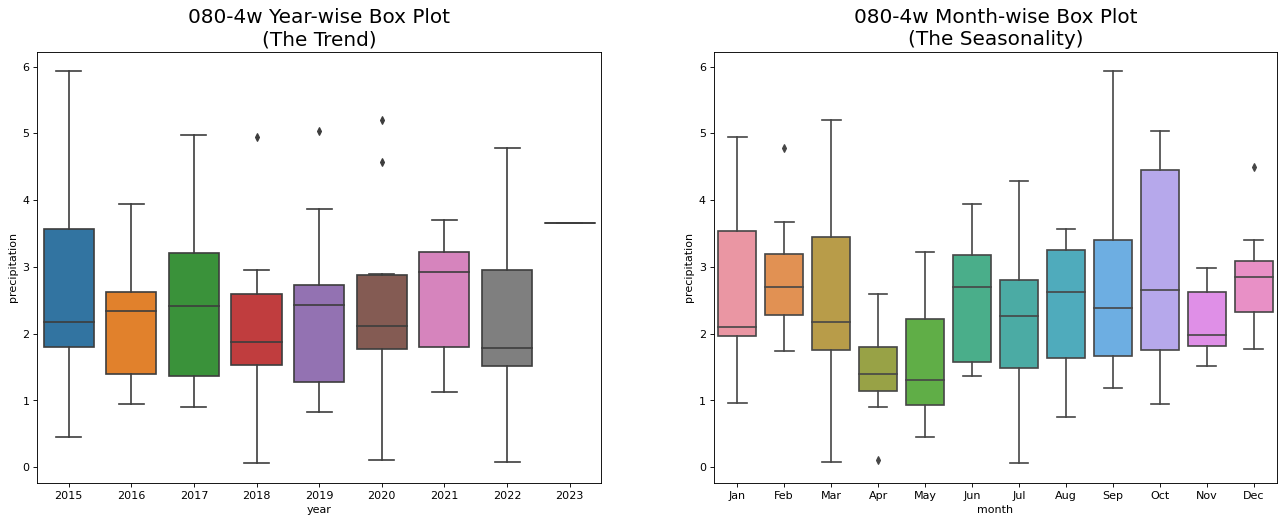

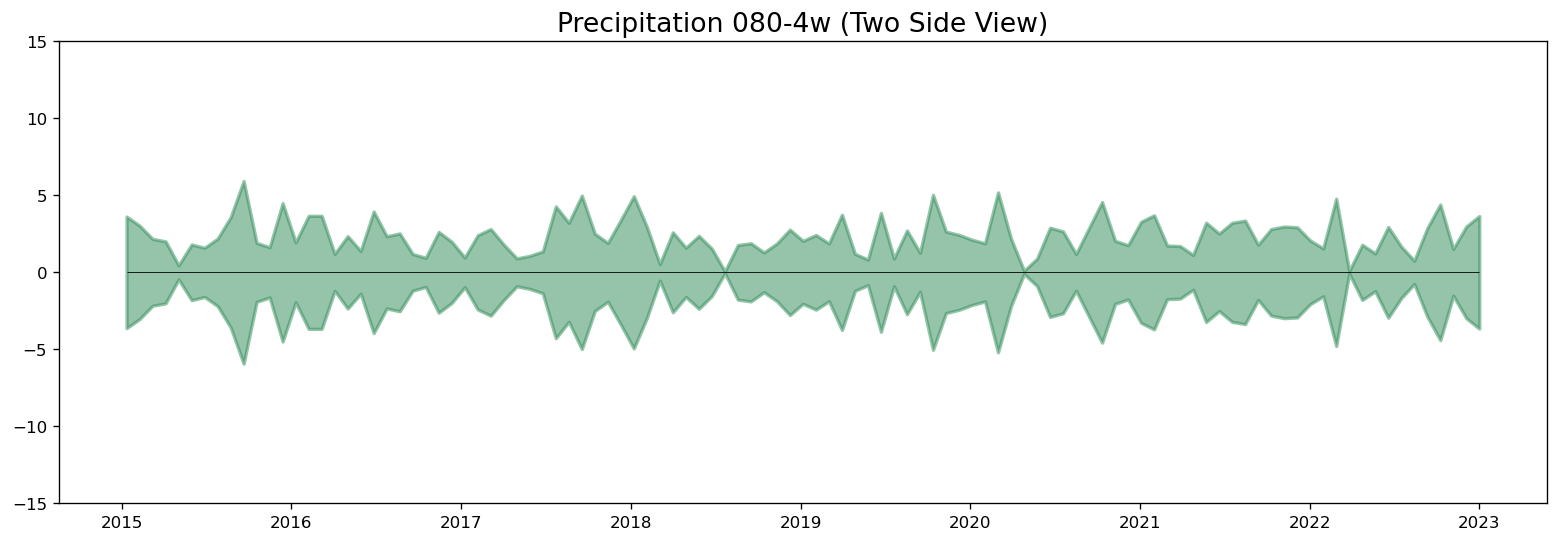

<bound method Index.min of DatetimeIndex(['1956-01-01', '1956-01-29', '1956-02-26', '1956-03-25',
               '1956-04-22', '1956-05-20', '1956-06-17', '1956-07-15',
               '1956-08-12', '1956-09-09',
               ...
               '2022-07-17', '2022-08-14', '2022-09-11', '2022-10-09',
               '2022-11-06', '2022-12-04', '2023-01-01', '2023-01-29',
               '2023-02-26', '2023-03-26'],
              dtype='datetime64[ns]', name='date', length=878, freq=None)>


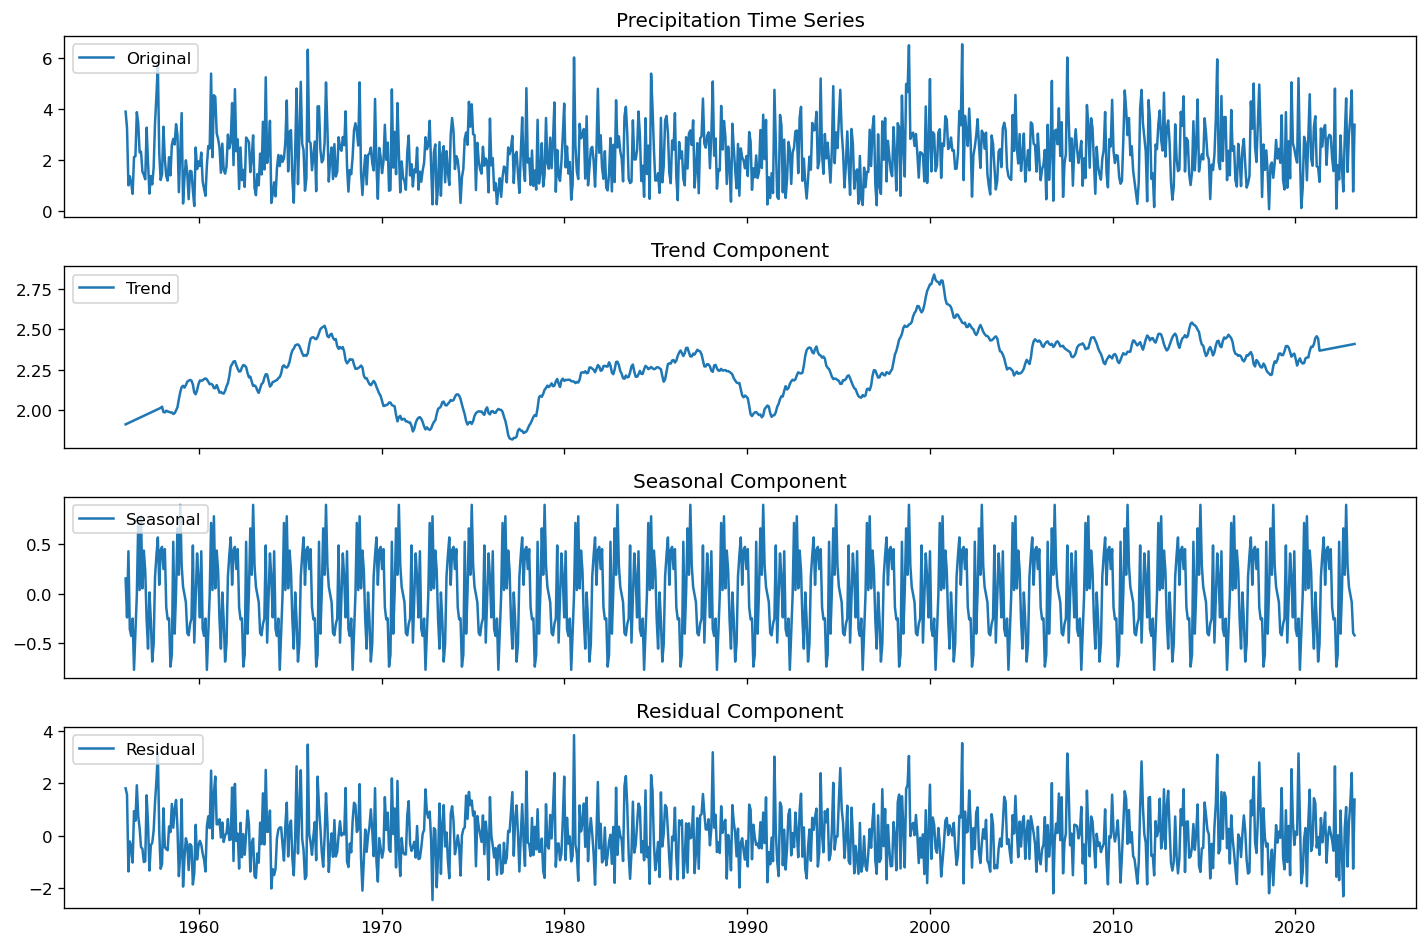

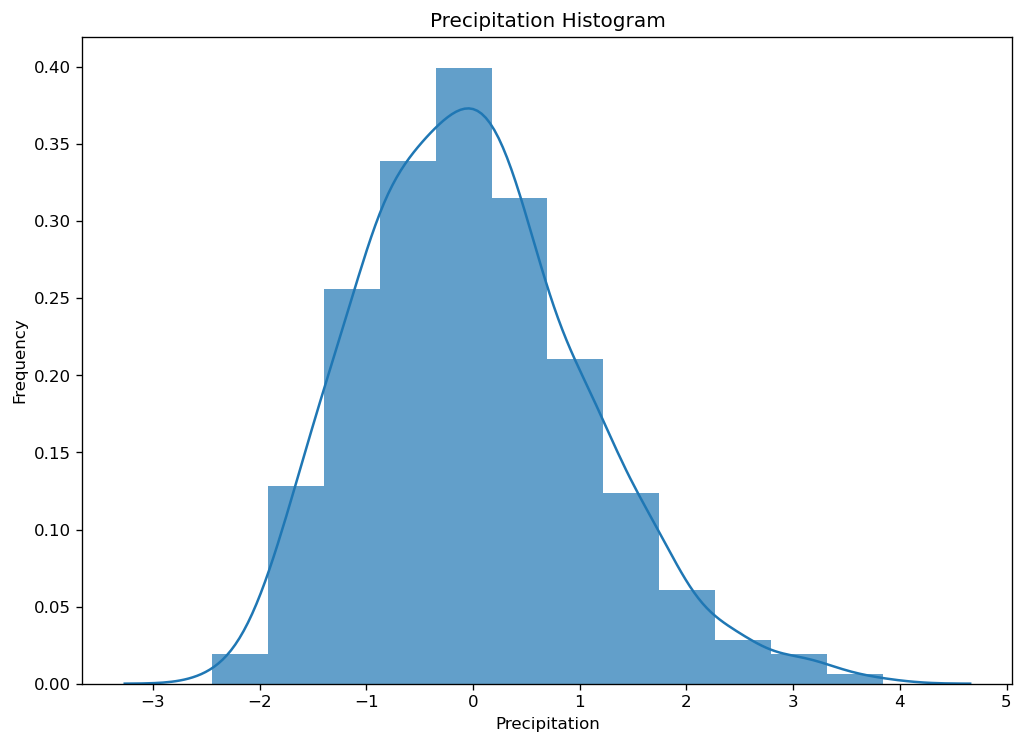

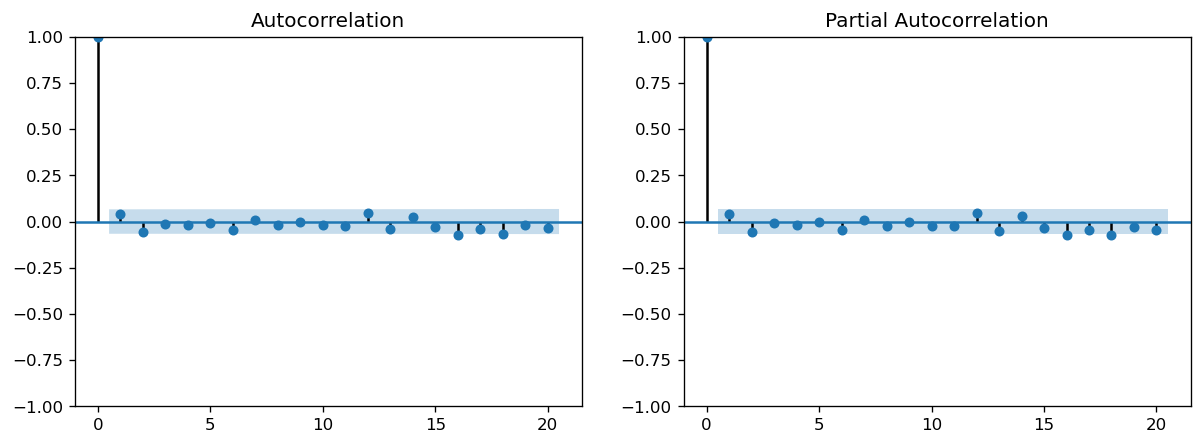

In [41]:
## LSTM for final DS
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping

# Hyper parameters
hyper_parameters = {
    'freq' : '4w',
    'look_back' : 12,
    'units' : 12,
    'dropout_rate' : 0.2,
    'optimizer' : 'adam'
}

look_back = hyper_parameters['look_back']
df_seasson = get_final_data(hyper_parameters['freq'])

# Check missing values
#check_missing_values(df_seasson)


# Seasonal Analysis
display(HTML(f'<h1>Seasonal Analysis - Combined Stations</h1>'))
display(HTML('<hr/><br/>'))
seasonality_plots(df_seasson,station,hyper_parameters['freq'],remove_outliers=False)

# Decomposition Analysis
display(HTML(f'<h1>Decomposition Analysis - Combined Stations</h1>'))
display(HTML('<hr/><br/>'))
decomposition = plot_seasonlity(df_seasson)
decomposition.resid.describe()

# Plot autocorrelation
plot_autocorrelation(decomposition)


> ## For monthly data there Auto-correlation found for values < 5 mm
> ## For aggregations on 4 weeks not tight to calendar months this autocorrelation is solved

# LSTM - Combined DS

6/6 [==============================] - 1s 3ms/step
RMSE: 0.2143934965133667


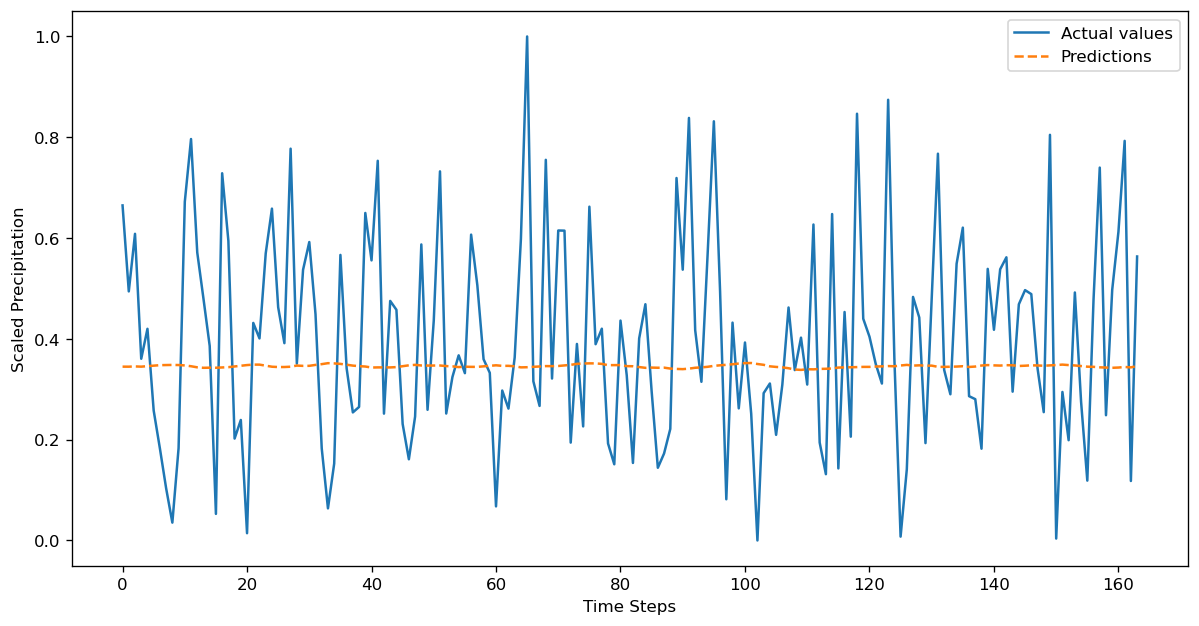

In [94]:
# Split dataset for test and training and create sequences.
df_seasson = get_final_data(hyper_parameters['freq'])
#df_seasson = get_specific_station_data('090',hyper_parameters['freq'])
train_data, test_data = train_test_split(df_seasson, test_size=0.2, shuffle=False)

# Scale datasets
train_data = get_scaled_data(train_data)
test_data = get_scaled_data(test_data)

# Create training and test sequences
train_X, train_y = create_sequences(train_data, look_back)
test_X, test_y = create_sequences(test_data, look_back)

train_X = train_X.reshape(train_X.shape[0], train_X.shape[1], 1)
test_X = test_X.reshape(test_X.shape[0], test_X.shape[1], 1)

# Create CNN model
model = create_rnn(hyper_parameters)

# Configure early stop
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=10, restore_best_weights=True)
model.fit(train_X, train_y, epochs=100, batch_size=5, verbose=0, validation_split=0.2, callbacks=[early_stopping])


predictions = model.predict(test_X)
rmse = 9999
if(np.any(np.isnan(predictions.flatten())) == False):
    rmse = np.sqrt(mean_squared_error(test_y, predictions.flatten()))

print(f"RMSE: {rmse}")
plt.figure(figsize=(12, 6))
plt.plot(test_y, label='Actual values')
plt.plot(predictions, label='Predictions', linestyle='dashed')
plt.xlabel('Time Steps')
plt.ylabel('Scaled Precipitation')
plt.legend()
plt.show()


# LSTM - Station 080

In [179]:
# Get only station with rmse lower than 2
rmse_filtered_dict = {k: v for k, v in stations_lstm_results.items() if v < 2}


In [180]:
rmse_filtered_dict['080']

0.13211404

In [199]:
df_seasson = get_station_data('080','M')
# Hyper parameters
hyper_parameters = {
    'freq' : 'M',
    'look_back' : 12,
    'units' : 12,
    'dropout_rate' : 0.2,
    'optimizer' : 'adam'
}

print(run_training(df_seasson, hyper_parameters, True))

# LSTM 2 RNN with hyper parameter tunning

In [215]:
# Aggregate data on a monthly basis
df_seasson = get_station_data('080','M')

# Define look_back
look_back = 12

# Prepare the dataset
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)

# Split into train and test sets
train, test = train_test_split(df_seasson, test_size=0.2, shuffle=False)
train_values = train.values.astype('float32')
test_values = test.values.astype('float32')

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_values = scaler.fit_transform(train_values)
test_values = scaler.transform(test_values)

# Create train and test datasets
X_train, y_train = create_dataset(train_values, look_back)
X_test, y_test = create_dataset(test_values, look_back)

# Reshape data for CNN input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build the LSTM-based CNN model
def create_model(units = 12, look_back = 12, optimizer='adam', dropout_rate = 0.2):
    
    model = Sequential()
    model.add(LSTM(units, input_shape=(look_back, 1), return_sequences=True))
    model.add(Dropout(dropout_rate))

    model.add(LSTM(units = units, return_sequences = True))
    model.add(Dropout(dropout_rate))

    model.add(LSTM(units))
    model.add(Dropout(dropout_rate))

    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    
    return model

# Perform hyperparameter tuning
model = KerasRegressor(build_fn=create_model, verbose=0)
param_grid = {
    'look_back' : [look_back],
    'epochs': [50],
    'batch_size': [16],
    'units' : [look_back],
    'dropout_rate' : [0.2],
    'optimizer': ['adam']
    
}

hyper_parameters = {
    'freq' : 'M',
    'look_back' : 12,
    'units' : 12,
    'dropout_rate' : 0.2,
    'optimizer' : 'adam'
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

# This could take a few minutes to complete

2023-04-06 22:19:08.494688: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-04-06 22:19:08.987956: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-04-06 22:19:09.183033: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [219]:
grid_result.best_params_

{'batch_size': 16,
 'dropout_rate': 0.2,
 'epochs': 50,
 'look_back': 12,
 'optimizer': 'adam',
 'units': 12}

In [220]:
# Train the model
best_epochs = grid_result.best_params_['epochs']
best_batch_size = grid_result.best_params_['batch_size']
model = create_model(units =  grid_result.best_params_['units'],
                     look_back = grid_result.best_params_['look_back'],
                     optimizer= grid_result.best_params_['optimizer'], 
                     dropout_rate = grid_result.best_params_['dropout_rate'])

# Include Early Stop if learning doesn't improve on delta 0.00001 after 10 epochs
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=best_epochs, batch_size=best_batch_size, verbose=0, validation_split=0.2, callbacks=[early_stopping])


In [221]:
# Predict precipitation using the trained model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Calculate evaluation metrics
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
train_mae = mean_absolute_error(y_train, train_predict)
train_mape = np.mean(np.abs((y_train - train_predict) / y_train)) * 100
train_mase = train_mae / (np.mean(np.abs(y_train[1:] - y_train[:-1])))

test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
test_mae = mean_absolute_error(y_test, test_predict)
test_mape = np.mean(np.abs((y_test - test_predict) / y_test)) * 100
test_mase = test_mae / (np.mean(np.abs(y_test[1:] - y_test[:-1])))

print(f"Train RMSE: {train_rmse:.2f}, Test RMSE: {test_rmse:.2f}")
print(f"Train MAE: {train_mae:.2f}, Test MAE: {test_mae:.2f}")
print(f"Train MAPE: {train_mape:.2f}%, Test MAPE: {test_mape:.2f}%")
print(f"Train MASE: {train_mase:.2f}, Test MASE: {test_mase:.2f}")

6/6 [==============================] - 0s 3ms/step
Train RMSE: 0.13, Test RMSE: 0.13
Train MAE: 0.10, Test MAE: 0.11
Train MAPE: inf%, Test MAPE: 87.60%
Train MASE: 0.78, Test MASE: 0.75


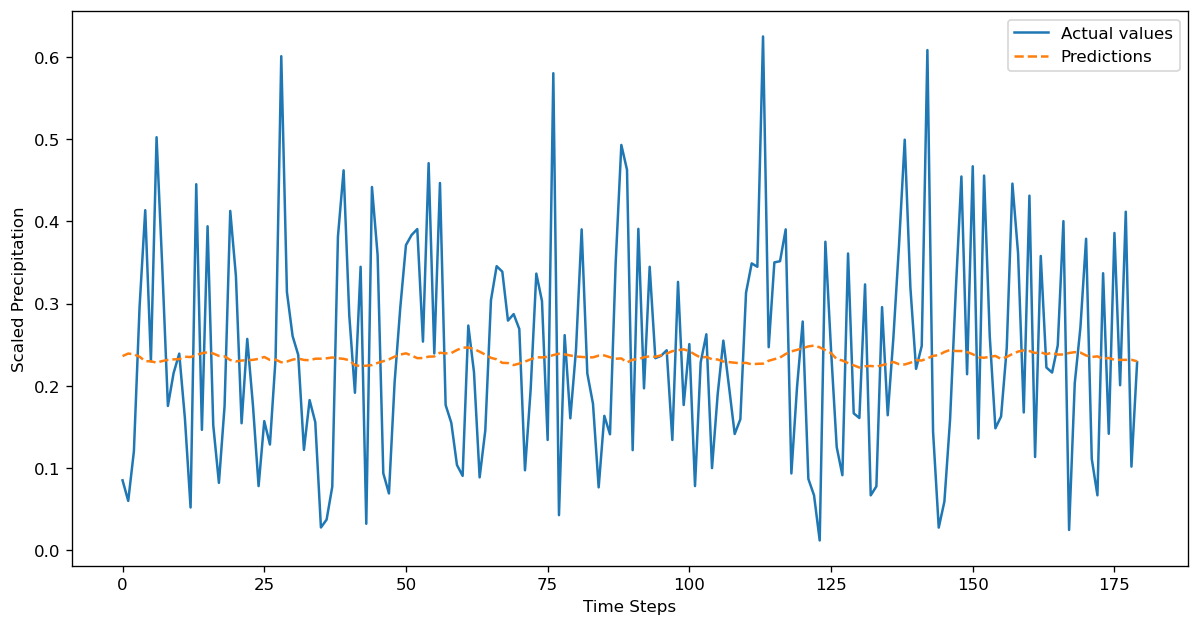

In [222]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual values')
plt.plot(test_predict, label='Predictions', linestyle='dashed')
plt.xlabel('Time Steps')
plt.ylabel('Scaled Precipitation')
plt.legend()
plt.show()


In [ ]:
# Hyper parameters
hyper_parameters = {
    'freq' : '1M',
    'look_back' : 12,
    'units' : 12,
    'dropout_rate' : 0.2,
    'optimizer' : 'adam'
}

def create_rnn(hyper_parameters):
    units = hyper_parameters['units']
    look_back = hyper_parameters['look_back']
    optimizer = hyper_parameters['optimizer']
    dropout_rate = hyper_parameters['dropout_rate']
    
    print("Hyper-parameters:")
    print(f"\tfreq: { hyper_parameters['freq']}")
    print(f"\tunits: {units}")
    print(f"\tlook_back: {look_back}")
    print(f"\tdropout_rate: {dropout_rate}")
    print(f"\toptimizer: {optimizer}")
    
          
    
    model = Sequential()
    model.add(LSTM(units, input_shape=(look_back, 1), return_sequences=True))
    model.add(Dropout(dropout_rate))

    model.add(LSTM(units = units, return_sequences = True))
    model.add(Dropout(dropout_rate))

    model.add(LSTM(units = units, return_sequences = True))
    model.add(Dropout(dropout_rate))

    model.add(LSTM(units))
    model.add(Dropout(dropout_rate))

    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    
    return model

# Get Dataset
scaled_data = get_scaled_data(df, hyper_parameters)

look_back = hyper_parameters['look_back']

# Split dataset for test and training and create sequences.
train_data, test_data = train_test_split(scaled_data, test_size=0.2, shuffle=False)

# Create training and test sequences
train_X, train_y = create_sequences(train_data, look_back)
test_X, test_y = create_sequences(test_data, look_back)

train_X = train_X.reshape(train_X.shape[0], train_X.shape[1], 1)
test_X = test_X.reshape(test_X.shape[0], test_X.shape[1], 1)

# Create CNN model
model = create_rnn(hyper_parameters)

# Configure early stop
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, restore_best_weights=True)
model.fit(train_X, train_y, epochs=100, batch_size=5, verbose=1, validation_split=0.2, callbacks=[early_stopping])


predictions = model.predict(test_X)
rmse = np.sqrt(mean_squared_error(test_y, predictions.flatten()))
print(f"RMSE: {rmse}")